# Generative Adversarial Networks - Sine Graph
Source: https://realpython.com/generative-adversarial-networks/

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

torch.manual_seed(111)

### Preparing the training data

In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
# create tensor of labels, required by PyTorch’s data loader
# GANs make use of unsupervised learning techniques
# so labels can be anything as they won't be used
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

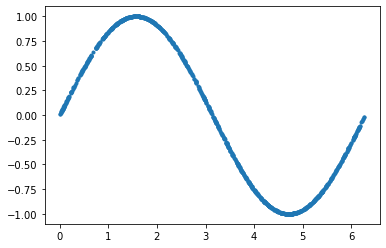

In [3]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### Implementing the Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [6]:
discriminator = Discriminator()

### Implementing the Generator

In [7]:
class Generator (nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32,2)
        )
        
    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
generator = Generator()

### Training the Models
Binary cross-entropy function is a suitable loss function for training the discriminator because it considers a binary classification task. It is also suitable for training the generator since the generator feeds its output to the discriminator, which provides a binary observable output.

In [9]:
lr = 0.001 # learning rate
num_epochs = 300 # number of epochs
loss_function = nn.BCELoss() # binary cross-entropy loss function

In [10]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2)) # input to be fed to generator
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.21308739483356476
Epoch: 0 Loss G.: 1.7989580631256104
Epoch: 10 Loss D.: 0.6099680662155151
Epoch: 10 Loss G.: 0.9077385067939758
Epoch: 20 Loss D.: 0.620063066482544
Epoch: 20 Loss G.: 0.9532096982002258
Epoch: 30 Loss D.: 0.6275916695594788
Epoch: 30 Loss G.: 0.9946527481079102
Epoch: 40 Loss D.: 0.6435611248016357
Epoch: 40 Loss G.: 1.0653221607208252
Epoch: 50 Loss D.: 0.6671847105026245
Epoch: 50 Loss G.: 0.7874217629432678
Epoch: 60 Loss D.: 0.7019680142402649
Epoch: 60 Loss G.: 0.7117553949356079
Epoch: 70 Loss D.: 0.6384673118591309
Epoch: 70 Loss G.: 0.8765016198158264
Epoch: 80 Loss D.: 0.6774991154670715
Epoch: 80 Loss G.: 0.9078847169876099
Epoch: 90 Loss D.: 0.6131874322891235
Epoch: 90 Loss G.: 0.8677703738212585
Epoch: 100 Loss D.: 0.6628223657608032
Epoch: 100 Loss G.: 0.6715638637542725
Epoch: 110 Loss D.: 0.7007931470870972
Epoch: 110 Loss G.: 0.6893211007118225
Epoch: 120 Loss D.: 0.6354084014892578
Epoch: 120 Loss G.: 0.9710942506790161
Epoch: 1

### Reviewing the GAN Generator

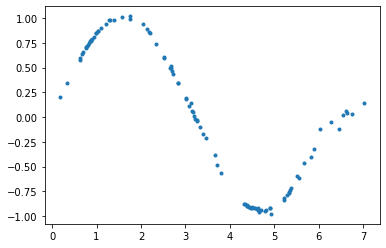

In [12]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
# .detach() constructs a new view on a tensor which is declared not to need gradients
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

At the beginning of the training process, the generated data distribution is very different from the real data. However, as the training progresses, the generator learns the real data distribution.